# LOFTI: Orbit Fitting of Wide Stellar Binaries with Gaia DR2

The LOFTI-Gaia package will fit orbital elements to the astrometry provided by Gaia DR2 only.

Written by Logan A. Pearce, 2020<br>
If you use LOFTI in your work please cite Pearce et al. 2020

## LOFTI Gaia DR2
LOFTI Gaia DR2 uses measurements from Gaia of resolved stellar binaries to provide loose constraint of orbital parameters for the pair.  It makes use of the Orbits for the Impatient (OFTI) methodology to accomplish the fit.  Care should be taken to understand the quality of the astrometric solution of the two objects before trying to apply the method.  It will give you answers, you should be sure the answers are somewhat reliable before trying to use the results.  Garbage in garbage out, as it were.  For a detailed discussion of when LOFTI results are and are not trustworthy, and how to approach making this assessment, please review Pearce et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020ApJ...894..115P/abstract)

## Fitting orbital parameters:

LOFTI takes only the Gaia DR2 source IDs of the two objects and their mass estimates as input parameters.  Mass is not taken as a free parameter and must be estimated via outside means.

For our test case, let's look at DS Tuc AB system.  DS Tuc A has a transiting exoplanet, as reported in Newton et al 2019 (https://ui.adsabs.harvard.edu/abs/2019ApJ...880L..17N/abstract).  Both DS Tuc A and B are well resolved in Gaia DR2, and both have radial velocity measurements as well.  It is an excellent demonstration case.  LOFTI was used in Newton et al. 2019 to show the binary orbit is broadly aligned with the transiting planet.  DS Tuc AB was used as the main demonstration case for the method in Pearce et al. 2020.

First we initialize the ```Fitter``` object.  This creates an object retrieves all the Gaia measurements for the system, computes the relative parameters for fitting the orbit, and some additional parameters for the system.  

In [1]:
# Gaia DR2 source ids:
DSTucA = 6387058411482257536
DSTucB = 6387058411482257280
# Mass estimates, must be a tuple of (value,uncertainty)
# in solar masses:
massA = (0.97, 0.04)
massB = (0.87, 0.04)

# Import the Fitter and FitOrbit objects:
from lofti_redesign import Fitter, FitOrbit

# Initialize the fitter object:
fitterobject = Fitter(DSTucA,           # source id object 1
                      DSTucB,           # source id object 2
                      massA,            # mass object 1
                      massB,            # mass object 2
                      Norbits = 100     # number of desired accepted orbits for the posterior orbit sample
                     )


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


We can examine properties of the system by calling on the ```Fitter``` object.  All measurements are tuples of the form (value, uncertainty)<br>
For example:

In [2]:
# Proper motion of B relative to A in RA in km s^-1:
print(fitterobject.pmRA)
# Distance to system in pc:
print(fitterobject.distance)
# Relative separation in mas:
print(fitterobject.sep)
# Relative separation in AU:
print(fitterobject.sep_au)

[-0.3016117396092139, 0.020378972692737377]
(44.13270628610624, 0.06890982448718509)
[5364.611925541039, 0.031174475323228305]
[236.75484244884555, 0.0013758139630635016]


The RUWE parameter quantifies the quality of the astrometric solution.  If one of the objects has an RUWE > 1.2, the code will ask if you wish to proceed.  Results from fitting with RUWE >~ 1.2 should be interpretted with caution, and RUWE > 1.4 should not be relied upon to be accurate.

In [3]:
GL896A = 2824770686019003904
GL896B = 2824770686019004032
GL896fitterobject = Fitter(GL896A,GL896B,massA,massB,Norbits = 10)
print(GL896fitterobject.ruwe1,GL896fitterobject.ruwe2)

1.1731006 1.4600381


A complete list of the system parameters is found in the documentation for the Fitter object.

## Run the fit
Next, run the actual fit by calling ```FitOrbit``` and giving the ```Fitter``` object you just created as input.  The ```FitOrbit``` object will give a progress bar updating the progress towards reaching Norbits orbits in the sample.  The ```FitOrbit``` object contains the posterior orbit sample from the fit.

In [4]:
# run orbit fit:
orbits = FitOrbit(fitterobject)

100% (100 of 100): |####################|  Done...


Three files are written out during the fit: 
- 1. FitResults.yr.mo.day.hr.min.s.txt : this is a human readable file of accepted orbits in order: semimajoraxis(arcsec),    period(yrs]),    t_o(yr),    ecc,    incl(deg),    argofperiastron(deg]),    posangleofnodes(deg), chisquaredvalue,    proboforbit,    randnum<br>
- 2. FitResults.yr.mo.day.hr.min.s.pkl : machine readable binary file of orbit results which can be read using the LoadResults function (more below)<br>
- 3. FitResults.Stats.yr.mo.day.hr.min.s.txt : a human readable text file of summary statistics from the sample posterior.<br>

You can choose your own filename for these outputs with the ```results_filename``` attribute in the Fitter object.<br>


In [5]:
# The orbit object contains the parameters used in the fit.  For example, the initial total system mass used 
# in the fit was:
print(orbits.mtot_init)
# The reference observation used in the fit was:
print(orbits.ref_epoch)
# (The Gaia DR2 reference date)
# How many orbits were requested:
print(orbits.Norbits)

[1.8399999999999999, 0.0565685424949238]
2015.5
100


## Working with fit results

Get the results by calling ```orbits.results```:

In [6]:
# get fit results:
results = orbits.results

This is the ```Results``` object that contains all the results from the fit.  We'll show here just a few things in the ```Results``` object class.  Full documentation can be found in the ```Results``` class.

In [7]:
# How long did it take to do that run?
print(results.run_time,results.run_time.to(u.min),results.run_time.to(u.hr))

184.97420382499695 s 3.0829033970832826 min 0.051381723284721376 h


We can examine the posterior orbital elements with dot notation on the ```results``` object.  The ```results``` orbital parameters are: 
- sma: semi-major axis in arcsec
- period: period in years
- orbit_fraction: fraction of orbit past periastron 
    passage the observation (2015.5) occured on.  Values: [0,1)
- t0: date of periastron passage in decimal years
- ecc: eccentricity
- inc: inclination relative to plane of the sky in deg
- aop: arguement of periastron in deg
- lan: longitude of ascending node in deg
- mtot: total system mass in Msun
- distance: distance to system in parsecs
- chi2: chi^2 value for the orbit
- lnprob: log probability of orbit
- lnrand: log of random "dice roll" for 
    orbit acceptance

In [9]:
print(results.sma)
print(results.ecc)

[ 5.54893702  4.35542484  3.50198847  5.6410168   5.6887166  13.21388572
  3.48786846  8.93830978  4.91348824  4.11496996]
[0.49751779 0.2888284  0.67136817 0.36339305 0.3836009  0.75343447
 0.9229093  0.40985976 0.87122107 0.98965694]


The ```results``` object also contains a ```Stats``` subclass that holds summary statistics of the posterior distributions for each parameter.  Each parameter contains the following summary statistics:

- param.mean: mean of parameter computed using np.mean
- param.median: np.median of parameter
- param.mode: mode of parameter
- param.std: standard deviation from np.std
- param.ci68: 68% minimum credible interval of form (lower bound, upper bound)
- param.ci95: 95% minimum credible interval


In [10]:
print(results.stats.sma.mean)
print(results.stats.aop.ci68)

5.940460589259442
(95.23906808328863, 253.9314959592835)


In [7]:
results.SaveResults('saving_results_test_file.pkl')

results.SaveResults(write_text_file = True, text_filename = 'saving_results_test_file.txt')

You can load results from a previous run using ```LoadResults```.  First you must make a new ```Results``` object, then load the pickle file into that object.  You can also compute summary statistics on the loaded results and write to txt file.

In [16]:
from lofti_redesign import Results, Stats
# Make a new results object and load previous results:
loaded_results = Results()
loaded_results.LoadResults("FitResults.from.a.previous.run.pkl")
print('Loaded results sma:',loaded_results.sma)

# make a stats object, compute the stats, and write out automatically
loaded_results.stats = Stats(orbits = loaded_results.orbits, write_to_file = True, filename =\
    "FitResults.Stats.from.a.previous.run.txt")
print('Loaded results sma mean:',loaded_results.stats.sma.mean)
print('Loaded results lan 68% CI:',loaded_results.stats.lan.ci68)

Loaded results sma: [4.24437603 3.89329871 3.9528082  4.89930919 3.4578694  8.3085165
 2.94485287 5.09772675 3.10962108 3.46766074]
Loaded results sma mean: 4.337603948353685
Loaded results lan 68% CI: (-2.5633711675828863, 346.8904533913395)


Or you can append the loaded results to the results of a current run.  Useful if your run is interupted prematurely.

In [8]:
print('Length of results before load:',len(results.sma))
# call the results object from the last run:
results.LoadResults("FitResults.from.a.previous.run.pkl", append = True)
# now the loaded results are appended to that run's results.
print('Length of results after load:',len(results.sma))

Length of results before load: 100
Length of results after load: 110


### On limiting aop and lan:

In the absence of radial velocity information, a degeneracy exists between argument of periastron and longitude of ascending node.  It is standard practice to limit one of those parameters to the range [0,180] deg.  LOFTI by default limits longitude of nodes if both objects do not have RVs in Gaia.  (A future upgrade is planned to allow user RV inputs).  Within the results class, there is an orbits attribute that contains the full orbital parameter arrays in a (13 x Norbits) array, with parameters in the same order as listed above.  The orbits attribute retains the original values, while the lan or aop attributes are on the limited range.

DS Tuc has RV in Gaia though, so we should not see it limited:

In [12]:
print(results.lan)
print(results.orbits[:,7] % 360)

[349.6445183  347.68277885 344.04329673 345.03595426 344.67567363
 338.69790303 356.79596766 347.55416804 358.07424932  51.08801196]
[349.6445183  347.68277885 344.04329673 345.03595426 344.67567363
 338.69790303 356.79596766 347.55416804 358.07424932  51.08801196]


GL 896 does not have RV info in Gaia DR2.  If we load some results from a fit of GL 896, we will see that the orbits attribute is not limited, while the lan attribute is.

In [19]:
# But if there is no RV info, lan is by default limited to [0,180] deg interval.  The orbits attribute preserved
# the original value, but the lan attribute is the limited value:
from lofti_redesign import Results
GL896results = Results()
GL896results.LoadResults("FitResults.from.a.previous.run.GL896.pkl")
# The lan attribute is limited to [0,180]:
print(GL896results.lan)
# The lan column of the orbits attribute is not:
print(GL896results.orbits[:,7] % 360)

[103.51916925  79.43607227  69.44309748 153.85043033  11.1353334
 114.86241257 152.97298379  79.06314597  37.5787509   78.32546499]
[283.51916925 259.43607227  69.44309748 153.85043033  11.1353334
 114.86241257 152.97298379 259.06314597  37.5787509   78.32546499]


In [20]:
# If we decide we don't want that, we can reset the lan attribute (mod 360 to remove negative values):
GL896results.lan = GL896results.orbits[:,7] % 360
print(GL896results.lan)

[283.51916925 259.43607227  69.44309748 153.85043033  11.1353334
 114.86241257 152.97298379 259.06314597  37.5787509   78.32546499]


In [10]:
# If we decide to limit aop instead, we can replace .aop with orbits[:,6] % 180, or we can add it as a keyword
# when we create the Results object:
GL896results = Results(limit_aop = True)
GL896results.LoadResults("FitResults.from.a.previous.run.GL896.pkl")
print(GL896results.aop)
# but the orbits attribute still preserves the original values:
print(GL896results.orbits[:,6])

[ 41.69068997  63.00417452 147.84648818  83.79366542 107.76567041
  64.71041604  79.51135996   2.05808274 124.46578454 178.71563349]
[ 41.69068997  63.00417452 147.84648818 263.79366542 107.76567041
 244.71041604 259.51135996   2.05808274 124.46578454 178.71563349]


## Plotting

Although you can use the attributes provided through the package to produce any number of your own plots, several plotting tools are provided with LOFTI.  They are contained within the ```Results``` class.

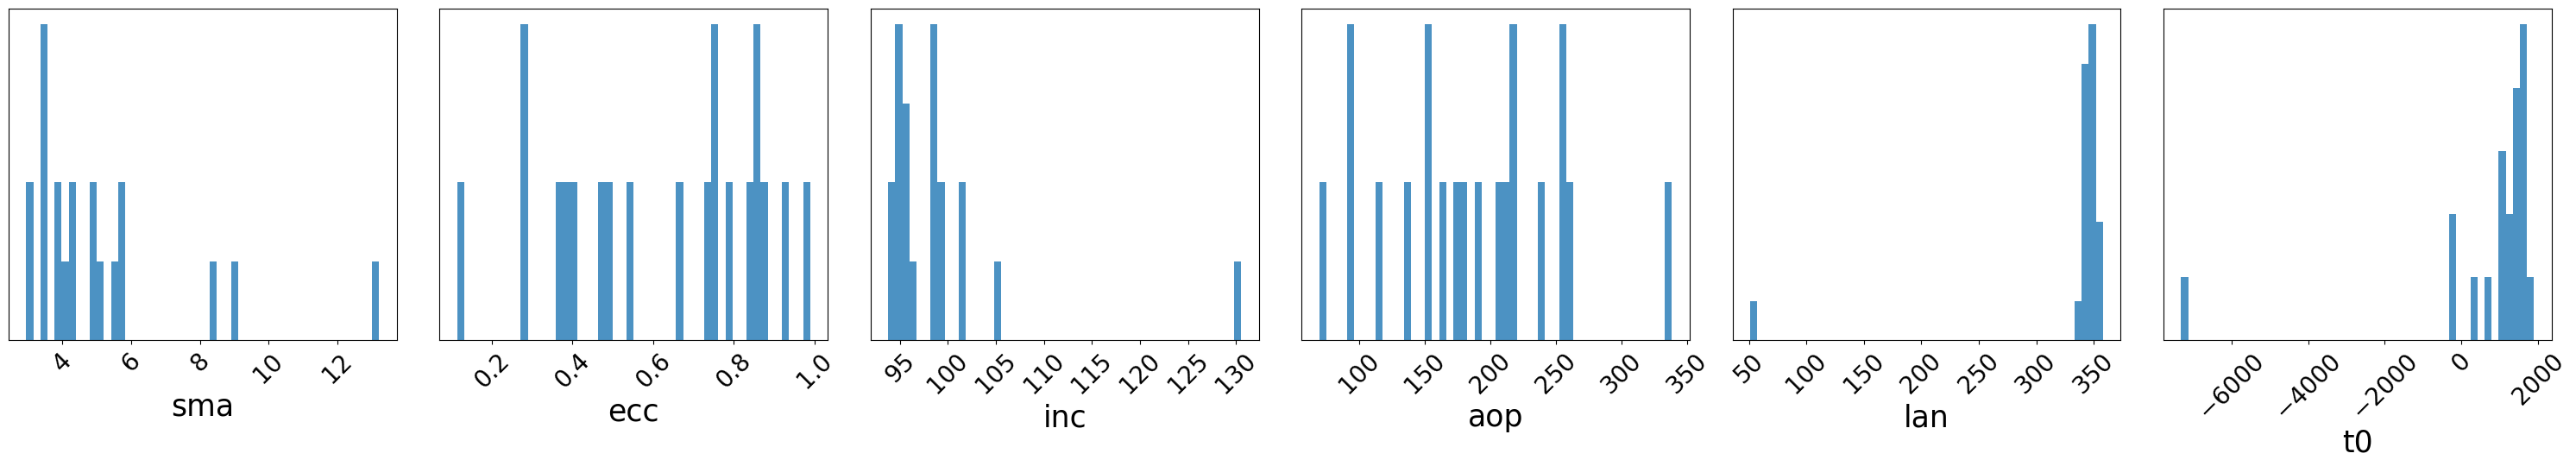

In [23]:
plt.style.use('default')
hists = results.PlotHists()

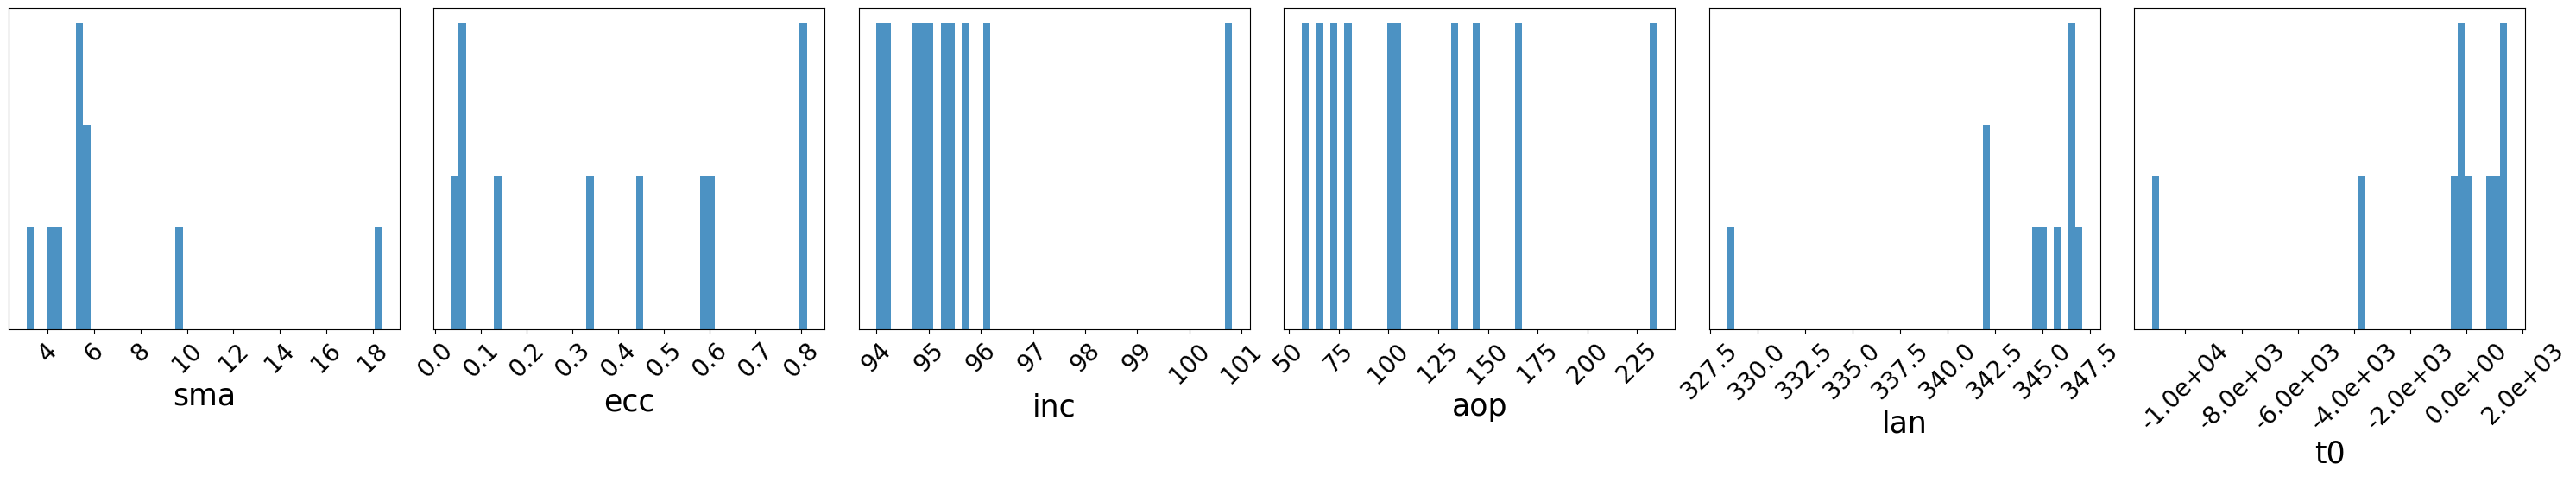

In [24]:
# You can make adjustments to the histograms by calling the individual histogram axes:
from matplotlib.ticker import FormatStrFormatter
# For example, change t0 to scientific notation:
hists.axes[-1].xaxis.set_major_formatter(FormatStrFormatter('%.1e'))
hists

Plot plane-of-sky orbits using ```PlotOrbits```.  If the orbit sample results are larger than 100, ```PlotOrbits``` will randomly select 100 orbits from the posterior sample to plot.

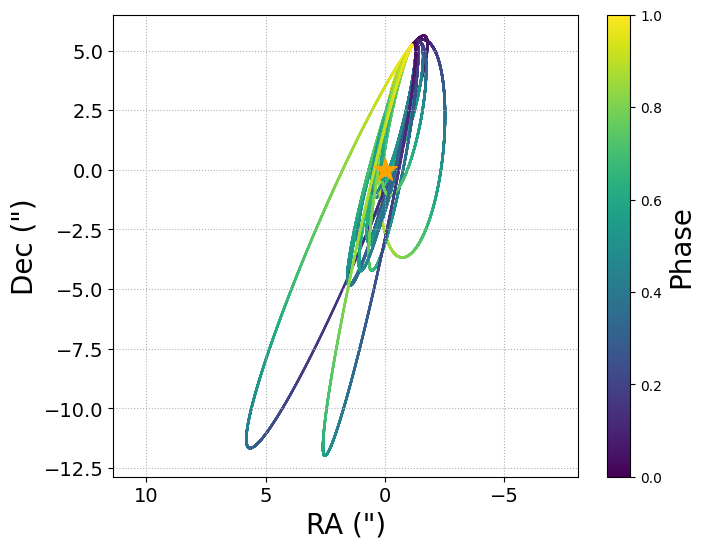

In [24]:
plotorbits = results.PlotOrbits()

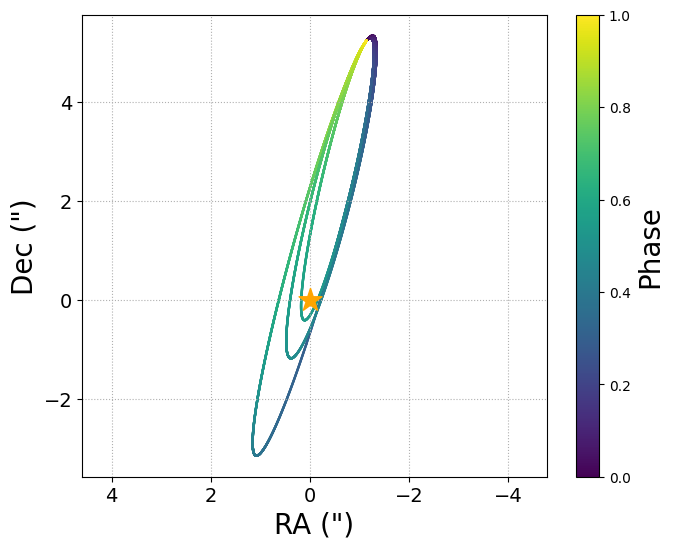

In [26]:
# If I want to plot fewer orbits, change the size keyword:
plotorbits = results.PlotOrbits(size = 3)

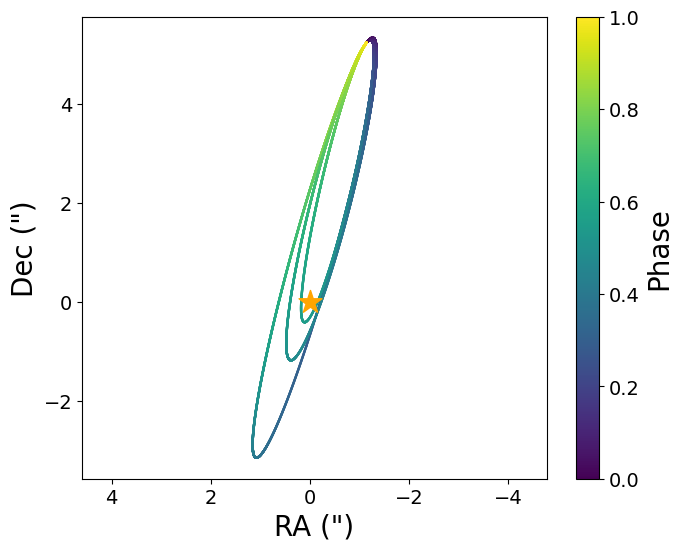

In [27]:
# the tick labels looks small
# on the colorbar:
plotorbits.axes[1].tick_params(labelsize=14)
# what if I don't want the grid lines?
plotorbits.axes[0].grid(b=False)
plotorbits

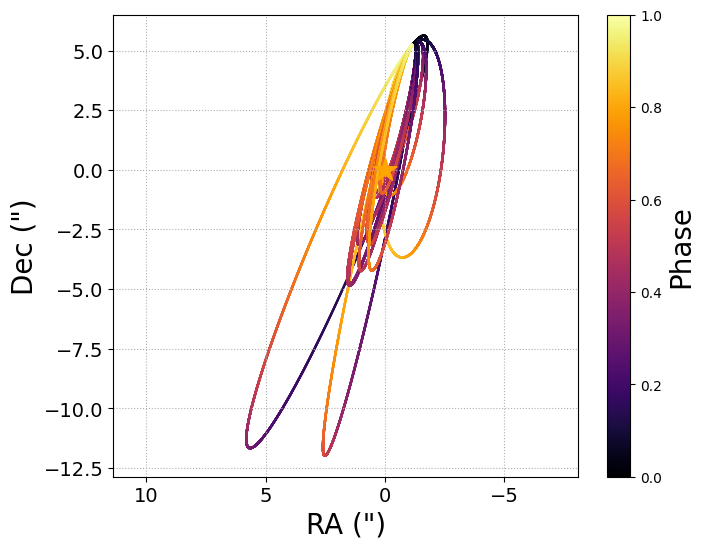

In [28]:
# What if I want a different color map?
plotorbits = results.PlotOrbits(cmap = 'inferno')

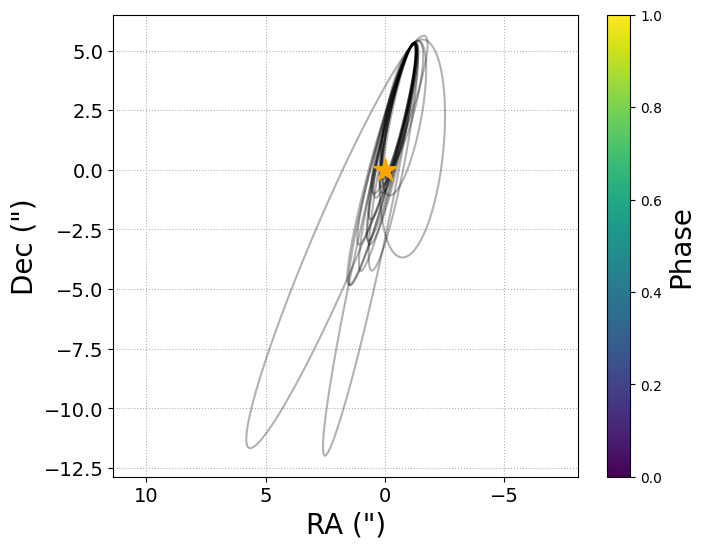

In [29]:
# Or no colormap at all?
plotorbits = results.PlotOrbits(color = False)

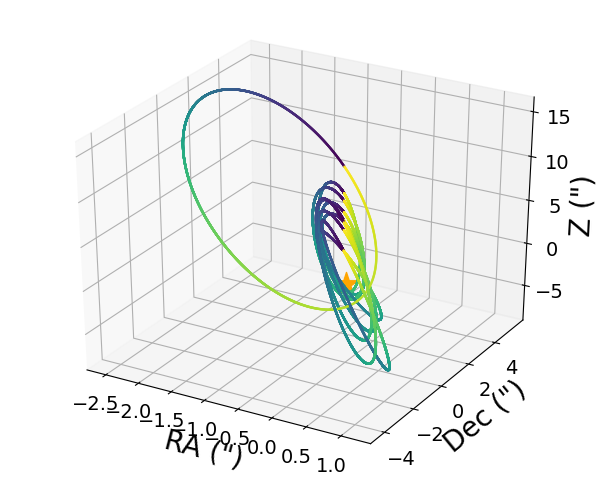

In [30]:
# You can make a 3d plot with the plot3d keyword:
from lofti_redesign import Results
loaded_results = Results(limit_lan = False)
loaded_results.LoadResults("FitResults.from.a.previous.run.pkl")
plotorbits3d = loaded_results.PlotOrbits(plot3d = True)

```PlotSepPA``` plots the orbits in separation and position angle vs time.

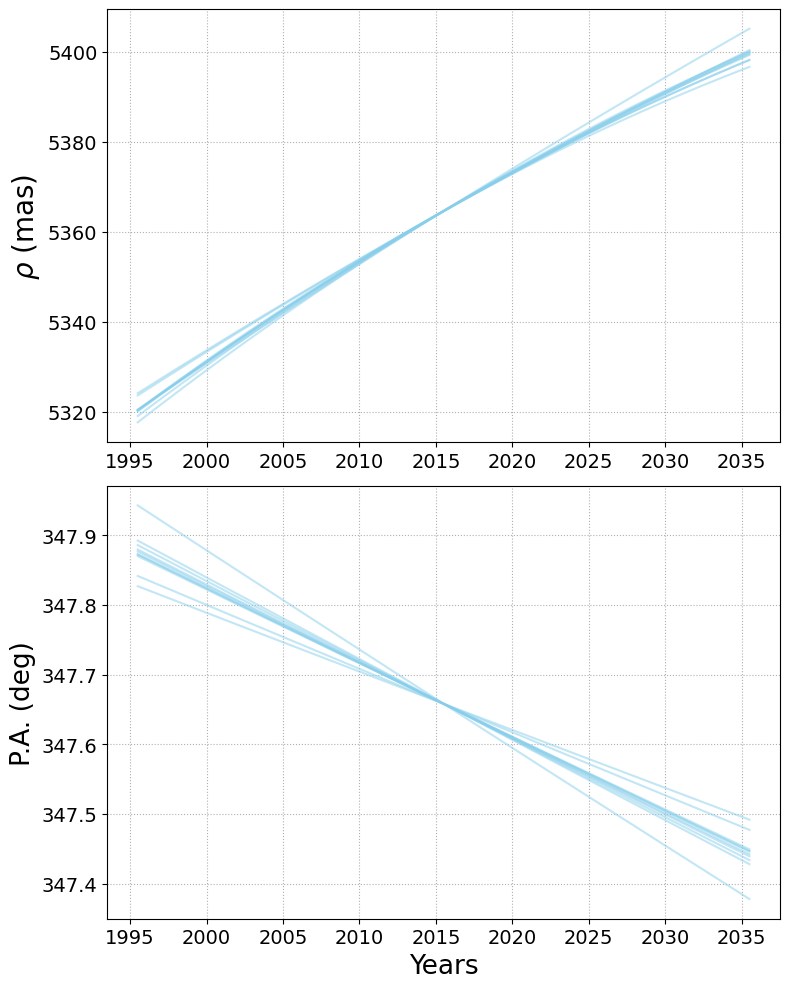

In [31]:
from lofti_redesign import Results
loaded_results = Results(limit_lan = False)
loaded_results.LoadResults("FitResults.from.a.previous.run.pkl")
plotseppa = loaded_results.PlotSepPA()

You can added scatter plot of astrometric points to the plot.  To reproduce the plot in Pearce et al. 2020 of DS Tuc AB Gaia fit compared to WDS astrometry points:

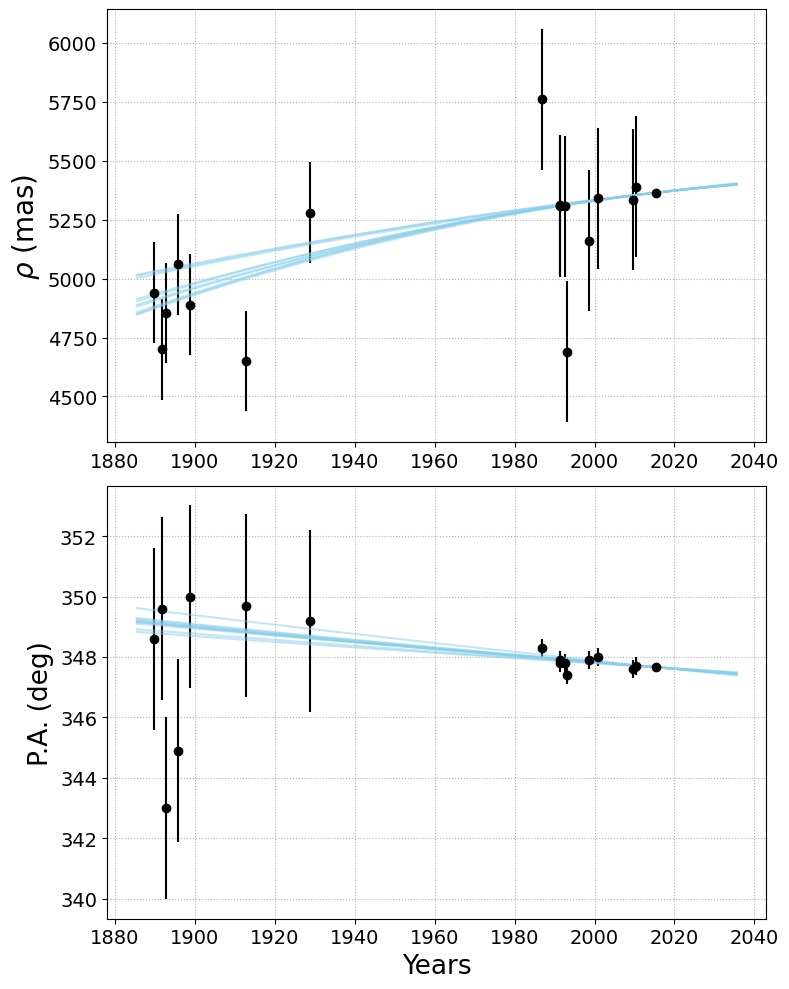

In [32]:
# Read in WDS astrometry:
import pandas as pd
WDS = pd.read_csv('WDS_DSTuc.csv')
# Adjust the time span of the plot to cover the range of WDS dates:
plotseppa = loaded_results.PlotSepPA(timespan=[130,20])
# Add the WDS scatter plot and error bars to the separation plot:
plotseppa.axes[0].errorbar(WDS['dates'],WDS['r'], yerr = WDS['rerr'], color='black', ls='none')
plotseppa.axes[0].scatter(WDS['dates'],WDS['r'], color = 'black', marker='o',zorder=10)
# Add to the position angle plot
plotseppa.axes[1].errorbar(WDS['dates'],WDS['PA'], yerr = WDS['PAerr'], color='black', ls='none')
plotseppa.axes[1].scatter(WDS['dates'],WDS['PA'], color = 'black', marker='o',zorder=10)
